In [152]:
import os

In [153]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
from lavis.models import model_zoo

In [155]:
print(model_zoo)

Architectures                  Types
albef_classification           ve
albef_feature_extractor        base
albef_nlvr                     nlvr
albef_pretrain                 base
albef_retrieval                coco, flickr
albef_vqa                      vqav2
alpro_qa                       msrvtt, msvd
alpro_retrieval                msrvtt, didemo
blip_caption                   base_coco, large_coco
blip_classification            base
blip_feature_extractor         base
blip_image_text_matching       base, large
blip_nlvr                      nlvr
blip_pretrain                  base
blip_retrieval                 coco, flickr
blip_vqa                       vqav2, okvqa, aokvqa
blip2_opt                      pretrain_opt2.7b, pretrain_opt6.7b, caption_coco_opt2.7b, caption_coco_opt6.7b
blip2_t5                       pretrain_flant5xl, pretrain_flant5xl_vitL, pretrain_flant5xxl, caption_coco_flant5xl
blip2_feature_extractor        pretrain, pretrain_vitL, coco
blip2                      

In [156]:
import torch

In [157]:
from PIL import Image

In [158]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [159]:
device

device(type='cuda')

In [160]:
raw_image = Image.open("docs/_static/merlion.png").convert("RGB")

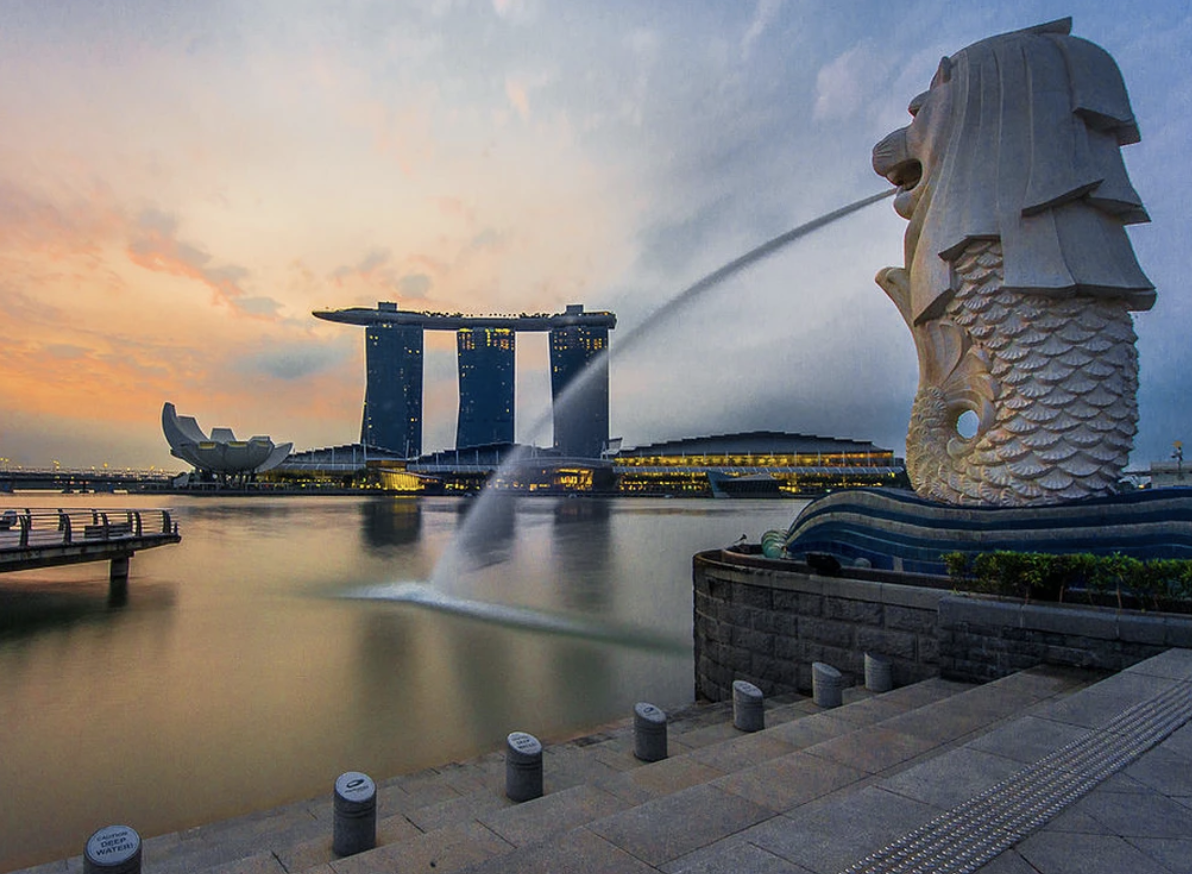

In [161]:
raw_image

In [162]:
from lavis.models import load_model_and_preprocess

# Image cpationing

In [163]:
# Load the image model and processor
model, vis_processor, _ = load_model_and_preprocess(
    name="blip_caption",
    model_type="base_coco",
    is_eval=True,
    device=device
)

  warnings.warn(



In [164]:
print(type(model))
print(vis_processor)

<class 'lavis.models.blip_models.blip_caption.BlipCaption'>
{'train': <lavis.processors.blip_processors.BlipImageTrainProcessor object at 0x7fb18e080160>, 'eval': <lavis.processors.blip_processors.BlipImageEvalProcessor object at 0x7fb18e0811e0>}


In [165]:
image = vis_processor['eval'](raw_image).unsqueeze(0).to(device)
model.generate({'image': image})

['a large fountain spewing water into the air']

# VQA

In [166]:
vqa_model, vqa_vis_processor, txt_processor = load_model_and_preprocess(
    name='blip_vqa', model_type='vqav2', is_eval=True, device=device
)

In [167]:
print(txt_processor)

{'train': <lavis.processors.blip_processors.BlipQuestionProcessor object at 0x7fb18cde5e70>, 'eval': <lavis.processors.blip_processors.BlipQuestionProcessor object at 0x7fb18da339a0>}


In [168]:
question = "How many fountains in this picture?"

In [169]:
vqa_model.predict_answers(
    samples={
        'image': vqa_vis_processor['eval'](raw_image).unsqueeze(0).to(device),
        'text_input': txt_processor['eval'](question),
    },
    inference_method='generate'
)

['3']

# Feature extraction inference

In [170]:
fe_model, fe_vis_processor, fe_text_processor = load_model_and_preprocess(
    name="blip_feature_extractor",
    model_type="base",
    is_eval=True,
    device=device,
)

In [171]:
caption= "fountain"
image = fe_vis_processor['eval'](raw_image).unsqueeze(0).to(device)
processed_caption = fe_text_processor['eval'](caption)

In [172]:
sample = {'image': image, 'text_input': [processed_caption]}

In [173]:
multi_model_feature = fe_model.extract_features(sample)

In [174]:
print(multi_model_feature)
print(multi_model_feature.multimodal_embeds.shape)

BlipOutputFeatures(image_embeds=tensor([[[-0.6380,  0.2451,  0.4562,  ...,  0.4156,  0.8799, -0.8536],
         [-0.1119, -0.5515,  0.4292,  ..., -0.0862,  0.7816,  0.4115],
         [ 0.0576, -0.1988,  0.3577,  ...,  0.5371,  0.0090,  0.2173],
         ...,
         [-0.8961,  0.5253,  0.1568,  ..., -0.5014,  0.4896,  0.0142],
         [-0.4881, -0.9923,  1.0421,  ...,  0.0702,  0.6113,  0.0169],
         [-0.2559, -0.6390,  0.7750,  ...,  0.1924,  0.1614, -0.1494]]],
       device='cuda:0'), image_embeds_proj=None, text_embeds=None, text_embeds_proj=None, multimodal_embeds=tensor([[[-0.0462, -0.1014,  0.0064,  ...,  0.0235,  0.1181,  0.0335],
         [ 0.1483,  0.0080,  0.0237,  ..., -0.0387,  0.0585,  0.0296],
         [-0.0663, -0.1624, -0.0103,  ...,  0.0759,  0.1441,  0.0576]]],
       device='cuda:0'))
torch.Size([1, 3, 768])


In [175]:
image_feature = fe_model.extract_features(sample, mode="image")

In [176]:
# Investigate the image features
print(image_feature)
print(image_feature.image_embeds.shape)  # [1, 197, 768]
print(image_feature.image_embeds_proj.shape)  # Low dimensional projected space [1, 197, 256]

BlipOutputFeatures(image_embeds=tensor([[[-0.6380,  0.2451,  0.4562,  ...,  0.4156,  0.8799, -0.8536],
         [-0.1119, -0.5515,  0.4292,  ..., -0.0862,  0.7816,  0.4115],
         [ 0.0576, -0.1988,  0.3577,  ...,  0.5371,  0.0090,  0.2173],
         ...,
         [-0.8961,  0.5253,  0.1568,  ..., -0.5014,  0.4896,  0.0142],
         [-0.4881, -0.9923,  1.0421,  ...,  0.0702,  0.6113,  0.0169],
         [-0.2559, -0.6390,  0.7750,  ...,  0.1924,  0.1614, -0.1494]]],
       device='cuda:0'), image_embeds_proj=tensor([[[ 0.0694, -0.0499,  0.0749,  ..., -0.0383, -0.1314,  0.0809],
         [-0.0091, -0.0154,  0.0544,  ..., -0.0839, -0.0827, -0.0450],
         [ 0.1084,  0.0508, -0.0346,  ..., -0.0926, -0.1083, -0.0141],
         ...,
         [-0.0187, -0.0098,  0.0131,  ...,  0.0516,  0.0828, -0.0237],
         [ 0.1125, -0.0094, -0.0149,  ..., -0.0381, -0.0268, -0.0653],
         [ 0.0857, -0.0767,  0.0320,  ...,  0.0450, -0.0106,  0.0407]]],
       device='cuda:0'), text_embeds=None

In [177]:
text_feature = fe_model.extract_features(sample, mode="text")

In [178]:
print(text_feature.text_embeds.shape)   # 1, 12, 256[]
print(text_feature.text_embeds_proj.shape)  # [1, 12, 256]

torch.Size([1, 3, 768])
torch.Size([1, 3, 256])


In [179]:
similarity = image_feature.image_embeds_proj[:,0,:] @ text_feature.text_embeds_proj[:,0,:].t()

In [180]:
print(similarity)

tensor([[0.2122]], device='cuda:0')


# Load dataset

In [190]:
from lavis.datasets.builders import dataset_zoo, load_dataset
from pprint import pprint

In [188]:
dataset_names = dataset_zoo.get_names()

In [191]:
pprint(dataset_names)

['aok_vqa',
 'aok_vqa_instruct',
 'audio_video_discrn',
 'audiocaps_mm_caption',
 'audiocaps_mm_caption_instruct',
 'audiocaps_mm_qa',
 'audioset_mm_caption',
 'audioset_mm_caption_instruct',
 'avsd_dialogue',
 'avsd_mm_dialogue_instruct',
 'blip_diffusion_finetune',
 'capfilt14m',
 'capfilt14m_instruct',
 'charade_caption',
 'charade_caption_instruct',
 'clotho_qa',
 'clothov2',
 'clothov2_instruct',
 'coco_caption',
 'coco_caption_instruct',
 'coco_retrieval',
 'coco_vqa',
 'coco_vqa_instruct',
 'coin_caption',
 'coin_caption_instruct',
 'conceptual_caption_12m',
 'conceptual_caption_12m_instruct',
 'conceptual_caption_3m',
 'conceptual_caption_3m_instruct',
 'didemo_retrieval',
 'esc50_cls',
 'flickr30k',
 'flickr30k_caption',
 'flickr30k_caption_instruct',
 'gqa',
 'gqa_instruct',
 'iconqa',
 'iconqa_instruct',
 'image_pc_discrn',
 'imagenet',
 'laion2B_multi',
 'laion400M',
 'laion400M_instruct',
 'llava150k_dialogue_instruct',
 'modelnet40_cls',
 'msrvtt_caption',
 'msrvtt_captio

In [192]:
coco_dataset = load_dataset("vg_caption")

Using downloaded and verified file: /jupyter-users-home/tan-2enguyen/datasets/vlm/vg/annotations/vg_caption.json


In [193]:
coco_dataset

{'train': <lavis.datasets.datasets.image_text_pair_datasets.ImageTextPairDataset at 0x7fb17e148460>}